# Classificação dos niveis de MHI usando dados sociodemograficos;
- Neste projeto será utilizado a base de dados da dissertação "QUALIDADE DE VIDA E SAÚDE MENTAL DE ESTUDANTES UNIVERSITÁRIOS" de autoria de LYCÉLIA DA SILVA OLIVEIRA, para usar dados sociodemograficos e de qualidade de vida para classificar os niveis de saude mental dos estudantes universitarios da UVA.

## 1 - Importando Dados e Bibliotecas

In [1]:
# Importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

#Importando modelos de machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

In [2]:
# Importando base de dados que contem o header
base = pd.read_csv('dataframe_socioeconomico_Niveis.csv')

# Dividindo entre X e y, pelo tamanho da base
X = base.drop('Nivel_MHI', axis=1)
y = base['Nivel_MHI']

print(X.head())

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

FileNotFoundError: [Errno 2] No such file or directory: 'dataframe_socioeconomico_Niveis.csv'

In [ ]:
# Dividindo a base entre treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


## 2 - Classificação com Modelos Baseline;
Inicialmente será testado alguns modelos baseline para verificar qual apresenta o melhor resultado, sem aplicar nenhum tipo de tratamento nos dados. Usei como baseline os seguintes modelos:
- (1) DummyClassifier
- (2) SVM
- (3) Random Forest
- (4) MLP
- (5) XGBoost

### 2.1 - Importando as bibliotecas necessárias;

In [ ]:
# Importando as bibliotecas necessárias
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Importando os modelos de classificação
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

### 2.2 - Separando os dados de treino e teste;
Agora será separado os dados de treino e teste, utilizado um k-fold de 10, ou seja, 10% dos dados serão utilizados para teste e 90% para treino. O random_state será fixado em 42 para que os resultados sejam reproduziveis.

Ainda será aplicado o LabelEncoder na variavel objetivo, pois os modelos não aceitam variaveis categóricas.

In [ ]:
# Dividindo a base entre treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


### 2.3 - Criando uma função para avaliar os modelos;

In [ ]:
# Criando uma função para avaliar os modelos
def avalia_modelo_cv(model, X_input, y_input, n, resultados_individuais=False):
    kf = KFold(n_splits=n)
    reports = []
    y_true = []
    y_pred_list = []
    X_array = X_input.values
    accuracy_list = []
    model_name = type(model).__name__
    for fold_idx, (train_index, test_index) in enumerate(kf.split(X_input)):
        X_input, X_test = X_array[train_index], X_array[test_index]
        y_train, y_test = y_input[train_index], y_input[test_index]
        model.fit(X_input, y_train)
        y_pred = model.predict(X_test)
        y_true.extend(y_test)
        y_pred_list.append(y_pred)
        report = classification_report(y_test, y_pred, zero_division=0)
        reports.append(report)
        accuracy_list.append(accuracy_score(y_test, y_pred))
        if resultados_individuais:
            print(f"Classification Report for fold {fold_idx + 1}:\n{report}\n")
    y_pred_total = np.concatenate(y_pred_list)
    print("-" * 45)
    print("model_name: ", model_name)
    print("Average Classification Report:")
    avg_report = classification_report(y_true, y_pred_total, zero_division=0)
    print(avg_report)
    #Retorna a acuracia media
    return accuracy_score(y_true, y_pred_total)



In [ ]:
# Função que chama os 4 modelos e retorna o resultado de cada um usando a função avalia_modelo_cv e imprime o resultado de cada um.

def avalia_dif_modelos_cv(X_train, y_test, cv):
    # Criando os modelos
    dummy_av = DummyClassifier(strategy='most_frequent')
    rf_av = RandomForestClassifier(n_jobs=-1)
    svm_av = SVC(kernel='rbf', gamma='auto', decision_function_shape='ovo')
    mlp_av = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000)
    xgb_av = XGBClassifier(n_jobs=-1)

    # Aplicando a função de avaliação
    dummy_fun_av = avalia_modelo_cv(dummy_av, X_train, y_test, cv)
    rf_fun_av = avalia_modelo_cv(rf_av, X_train, y_test, cv)
    svm_fun_av = avalia_modelo_cv(svm_av, X_train, y_test, cv)
    mlp_fun_av = avalia_modelo_cv(mlp_av, X_train, y_test, cv)
    xgb_fun_av = avalia_modelo_cv(xgb_av, X_train, y_test, cv)

    # Criando o dataframe com os resultados
    df_resultado = pd.DataFrame({'Modelo': ['Dummy', 'RF', 'SVM', 'MLP', 'XGB'],
                                 'Acurácia': [dummy_fun_av, rf_fun_av, svm_fun_av, mlp_fun_av, xgb_fun_av]})

    # Plotando o gráfico de barras
    sns.barplot(x='Modelo', y='Acurácia', data=df_resultado)
    plt.show("Desempenho dos modelos")
    %matplotlib inline

    return df_resultado

### 2.4 - Aplicando os modelos baseline;

In [ ]:
# Aplicando os modelos baseline
avalia_dif_modelos_cv(X_train, y_train, 5)

## 3 - Treinamento dos modelos com os dados balanceados;
Agora vamos treinar os modelos com os dados balanceados e verificar se o desempenho melhora.

### 3.0 - Importando as bibliotecas e definindo as funções;

In [30]:
# Importando as bibliotecas
import seaborn as sns
import matplotlib.pyplot as plt

# Bibliotecas para undersampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import ClusterCentroids

In [31]:
# Função que chama os 4 modelos e retorna o resultado de cada um usando a função avalia_modelo_cv e imprime o resultado de cada um.

def avalia_dif_modelos_cv(X_train, y_test, cv):
    # Criando os modelos
    dummy_av = DummyClassifier(strategy='uniform')
    rf_av = RandomForestClassifier(n_jobs=-1)
    svm_av = SVC(kernel='rbf', gamma='auto', decision_function_shape='ovo')
    mlp_av = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000)
    xgb_av = XGBClassifier(n_jobs=-1)

    # Aplicando a função de avaliação
    dummy_fun_av = avalia_modelo_cv(dummy_av, X_train, y_test, cv)
    rf_fun_av = avalia_modelo_cv(rf_av, X_train, y_test, cv)
    svm_fun_av = avalia_modelo_cv(svm_av, X_train, y_test, cv)
    mlp_fun_av = avalia_modelo_cv(mlp_av, X_train, y_test, cv)
    xgb_fun_av = avalia_modelo_cv(xgb_av, X_train, y_test, cv)

    # Criando o dataframe com os resultados
    df_resultado = pd.DataFrame({'Modelo': ['Dummy', 'RF', 'SVM', 'MLP', 'XGB'],
                                 'Acurácia': [dummy_fun_av, rf_fun_av, svm_fun_av, mlp_fun_av, xgb_fun_av]})

    # Plotando o gráfico de barras
    sns.barplot(x='Modelo', y='Acurácia', data=df_resultado)
    plt.show("Desempenho dos modelos")
    %matplotlib inline

    return df_resultado

In [32]:
# Dividindo os dados de treino e teste
X_train_re, X_test_re, y_train_re, y_test_re = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

### 3.1 - Visualizando o balanceamento dos dados;

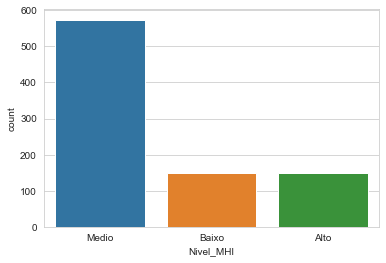

,Total,Porcentagem
Medio,574,65.83
Baixo,149,17.09
Alto,149,17.09


In [33]:
# Plotando o gráfico de barras para verificar o balanceamento dos dados
sns.countplot(x='Nivel_MHI', data=base)
plt.show("Balanceamento dos dados")
%matplotlib inline

# Calcular a porcentagem de cada classe e imprimir como uma tabela
total = base['Nivel_MHI'].value_counts()
percent = round(base['Nivel_MHI'].value_counts() / len(base) * 100, 2)
pd.concat([total, percent], axis=1, keys=['Total', 'Porcentagem'])

### 3.2 - Undersampling;
Neste caso, vamos aproveitar o tamanho da base de dados que temos e vamos reduzir a quantidade de dados da classe majoritária para o mesmo tamanho da classe minoritária.
Tecnicas de undersampling:
- (1) - RandomUnderSampling
- (2) - NearMiss
- (3) - ????


#### (1) - RandomUnderSampling;

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.36      0.33        98
           1       0.32      0.30      0.31        98
           2       0.25      0.22      0.24        98

    accuracy                           0.29       294
   macro avg       0.29      0.29      0.29       294
weighted avg       0.29      0.29      0.29       294

---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.69      0.69        98
           1       0.53      0.51      0.52        98
           2       0.46      0.47      0.46        98

    accuracy                           0.56       294
   macro avg       0.56      0.56      0.56       294
weighted avg       0.56      0.56      0.56       294

-------------------

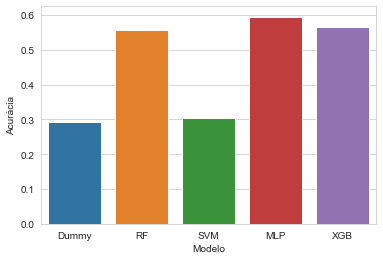

,Modelo,Acurácia
0,Dummy,0.292517
1,RF,0.557823
2,SVM,0.302721
3,MLP,0.595238
4,XGB,0.564626


In [34]:
# Criando o objeto para aplicar o RandomUnderSampling
rus = RandomUnderSampler(random_state=42, replacement=True, sampling_strategy='auto')

# Aplicando o RandomUnderSampling
X_rus, y_rus = rus.fit_resample(X_train_re, y_train_re)

# Plotando o gráfico de barras para verificar o balanceamento dos dados
#sns.countplot(x=y_rus, data=df_socioeconomico)

# Aplicando a função de avaliação cruzada com os dados balanceados
avalia_dif_modelos_cv(X_rus, y_rus, 10)

In [46]:
# MOstrando o balanceamento dos dados antes e depois do balanceamento sem usar value counts


AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

#### (2) - NearMiss;

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.41      0.38        98
           1       0.36      0.37      0.37        98
           2       0.28      0.23      0.25        98

    accuracy                           0.34       294
   macro avg       0.33      0.34      0.33       294
weighted avg       0.33      0.34      0.33       294

---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.28      0.31        98
           1       0.40      0.38      0.39        98
           2       0.43      0.55      0.48        98

    accuracy                           0.40       294
   macro avg       0.40      0.40      0.39       294
weighted avg       0.40      0.40      0.39       294

-------------------

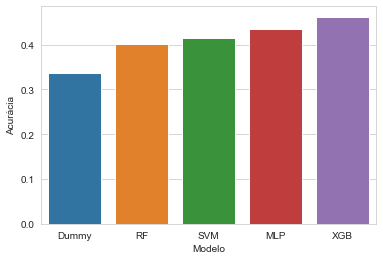

,Modelo,Acurácia
0,Dummy,0.336735
1,RF,0.401361
2,SVM,0.414966
3,MLP,0.435374
4,XGB,0.462585


In [35]:
# Criando o objeto para aplicar o NearMiss
nm = NearMiss(version=1)

# Aplicando o NearMiss
X_nm, y_nm = nm.fit_resample(X_train_re, y_train_re)

# Plotando o gráfico de barras para verificar o balanceamento dos dados
#sns.countplot(x=y_nm, data=df_socioeconomico)

# Aplicando a função de avaliação cruzada com os dados balanceados
avalia_dif_modelos_cv(X_nm, y_nm, 10)

### 3.3 - Oversampling;
Neste caso, vamos aproveitar o tamanho da base de dados que temos e vamos aumentar a quantidade de dados da classe minoritária para o mesmo tamanho da classe majoritária.
Tecnicas de oversampling:
- (1) - Random Over Sampling
- (2) - SMOTE-NC
- (3) - ROSE
- (4) - ADASYN

In [36]:
# Criando uma função que verifica quais colunas de um dataframe são categoricas e salva os indices em uma lista. Ela faz isso verificando se a coluna conte apenas 1 ou 0.
def verifica_categoricas(df):
    # Criando uma lista vazia para salvar os indices das colunas categóricas
    categorical_features = []

    # Loop para verificar as colunas
    for col in df.columns:
        # Verificando se a coluna conte apenas 1 ou 0, ou True ou False
        if df[col].isin([0, 1]).all() or df[col].isin([True, False]).all():
            # Salvando o indice da coluna na lista
            categorical_features.append(df.columns.get_loc(col))

    # Retornando a lista com os indices das colunas categóricas
    return categorical_features

#### (1) - SMOTE-NC

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.35      0.34       411
           1       0.34      0.33      0.33       411
           2       0.33      0.34      0.34       411

    accuracy                           0.34      1233
   macro avg       0.34      0.34      0.34      1233
weighted avg       0.34      0.34      0.34      1233

---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.88       411
           1       0.87      0.85      0.86       411
           2       0.74      0.78      0.76       411

    accuracy                           0.83      1233
   macro avg       0.83      0.83      0.83      1233
weighted avg       0.83      0.83      0.83      1233

-------------------

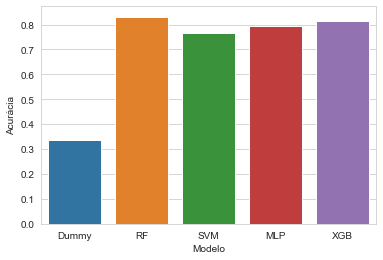

,Modelo,Acurácia
0,Dummy,0.336577
1,RF,0.831306
2,SVM,0.763990
3,MLP,0.794809
4,XGB,0.814274


In [37]:
# Importando o SMOTE-NC (Synthetic Minority Oversampling Technique for Nominal and Continuous)
from imblearn.over_sampling import SMOTENC

# Definindo as colunas categóricas, chamando a função criada anteriormente
c_features = verifica_categoricas(X)

# Criando o modelo SMOTE
smote = SMOTENC(c_features, random_state=42)

# Aplicando o SMOTE nos dados de treino
X_train_smote, y_train_smote = smote.fit_resample(X_train_re, y_train_re)

avalia_dif_modelos_cv(X_train_smote, y_train_smote, 10)

#### (2) - ROSE
Nesse caso vamos usar 'ROSE', mas é importante ressaltar que teremos dados categoricos e numericos, então vamos usar o rose para dados mistos.

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.35      0.33       411
           1       0.31      0.28      0.29       411
           2       0.37      0.36      0.37       411

    accuracy                           0.33      1233
   macro avg       0.33      0.33      0.33      1233
weighted avg       0.33      0.33      0.33      1233

---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       411
           1       0.93      1.00      0.96       411
           2       0.98      0.86      0.92       411

    accuracy                           0.95      1233
   macro avg       0.95      0.95      0.95      1233
weighted avg       0.95      0.95      0.95      1233

-------------------

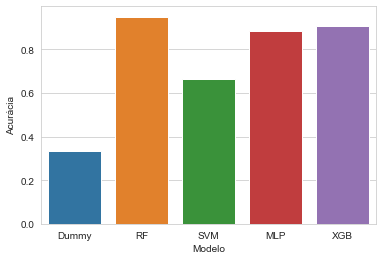

,Modelo,Acurácia
0,Dummy,0.331711
1,RF,0.949716
2,SVM,0.665045
3,MLP,0.884023
4,XGB,0.907543


In [39]:
# Importando o ROSE para dados mistos
from imblearn.over_sampling import RandomOverSampler
# Criando o modelo ROSE
rose = RandomOverSampler(random_state=43)

# Aplicando o ROSE nos dados de treino
X_train_rose, y_train_rose = rose.fit_resample(X_train_re, y_train_re)

# Aplicando a função de avaliação cruzada com os dados balanceados
avalia_dif_modelos_cv(X_train_rose, y_train_rose, 10)


              precision    recall  f1-score   support

           0       0.24      0.15      0.18        48
           1       0.37      0.20      0.26        51
           2       0.62      0.79      0.69       163

    accuracy                           0.55       262
   macro avg       0.41      0.38      0.38       262
weighted avg       0.50      0.55      0.51       262



## Aplicando Tecnicas de Tuning (Feature Selection e Hyperparameter Tuning);


In [ ]:
# TODO: Aplicar SFFS na base RandonOverSampling com o RF
# TODO: Aplicar SBFS na base RandonOverSampling com o RF
# TODO: Selecionar melhor e aplicar GridSearchCV e RandomizedSearchCV

In [74]:
# # Importando as bibliotecas necessárias
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Criando o modelo de classificação MLP
mlp_SFFS = MLPClassifier()
# Criando o objeto SFS
sffs = SFS(mlp_SFFS, k_features="best", forward=True, floating=True, scoring='accuracy', cv=5, n_jobs=-1)
# Aplicanod SFFS
sffs.fit(X_rus, y_rus)

SequentialFeatureSelector(estimator=MLPClassifier(), floating=True,
                          k_features=(1, 54), n_jobs=-1, scoring='accuracy')

In [75]:
# Criando o modelo de classificação para o SBFS
mlp_SBFS = MLPClassifier()
# Criando o objeto SBFS
sbfs = SFS(mlp_SBFS, k_features="best", forward=False, floating=True, scoring='accuracy', cv=5, n_jobs=-1)
# Aplicanod SBFS
sbfs.fit(X_rus, y_rus)

C:\Users\lucas\anaconda3\envs\BIC\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\lucas\anaconda3\envs\BIC\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\lucas\anaconda3\envs\BIC\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\lucas\anaconda3\envs\BIC\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\lucas\anaconda3\envs\BIC\Li

SequentialFeatureSelector(estimator=MLPClassifier(), floating=True,
                          forward=False, k_features=(1, 54), n_jobs=-1,
                          scoring='accuracy')

NameError: name 'sffs' is not defined

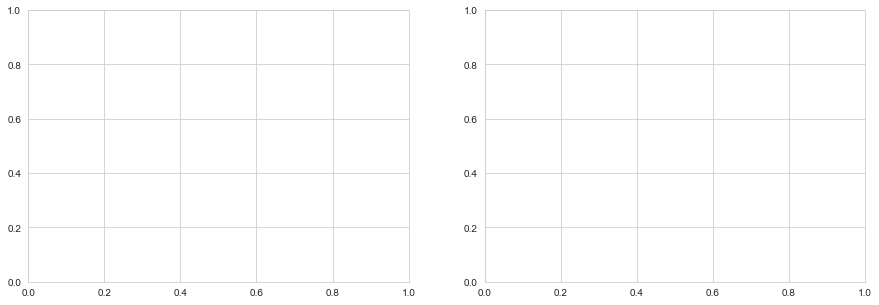

In [47]:
# Plotando o gráfico com os resultados do SFFS vs SBFS para verificar qual deles é melhor considerando que sffs.get_metrics_dict() retorna um dicionário com as métricas de cada iteração no formato numpy.float() e nao tem um atribulo plot()
# Marcar o melhor ponto de cada um no gráfico

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
pd.DataFrame.from_dict(sffs.get_metric_dict()).T[['avg_score']].plot(ax=ax[0], kind='line')
pd.DataFrame.from_dict(sbfs.get_metric_dict()).T[['avg_score']].plot(ax=ax[1], kind='line')
ax[0].set_title('SFFS')
ax[1].set_title('SBFS')
# Legenda eixo x
ax[0].set_xlabel('Num de Atributos')
ax[1].set_xlabel('Num de Atributos')
# Legenda eixo y
ax[0].set_ylabel('Acurácia')
ax[1].set_ylabel('Acurácia')

plt.show()

In [77]:
# Imprimindo o melhor score de cada um como um df mostrando apenas os 10 melhores, colunas "Number of Features" e "avg_score"
pd.DataFrame.from_dict(sffs.get_metric_dict()).T[['avg_score']].sort_values(by='avg_score', ascending=False).head(10)

,avg_score
33,0.703916
31,0.703916
32,0.70076
29,0.700643
27,0.693863
39,0.690532
28,0.690473
34,0.690415
35,0.687259
30,0.687084


In [78]:
# Imprimindo o melhor score de cada um como um df mostrando apenas os 10 melhores
pd.DataFrame.from_dict(sbfs.get_metric_dict()).T[['avg_score']].sort_values(by='avg_score', ascending=False).head(10)


,avg_score
19,0.714202
18,0.714202
15,0.714144
17,0.714144
16,0.714085
20,0.707306
23,0.704091
14,0.703974
26,0.700701
24,0.700643


In [79]:
# Imprimindo as features selecionadas por cada um de acordo com o nome original das colunas
print('SFFS: ', X_rus.columns[list(sffs.k_feature_idx_)])
print('SBFS: ', X_rus.columns[list(sbfs.k_feature_idx_)])


SFFS:  Index(['B', 'F', 'N', 'O', 'AD', 'AE', 'AO', 'AT', 'AU', 'AV', 'AW', 'AX',
       'AY', 'AZ', 'BD', 'BP', 'D_2.0', 'D_3.0', 'D_5.0', 'E_1.0', 'E_4.0',
       'I_1.0', 'I_3.0', 'I_4.0', 'J_1.0', 'J_4.0', 'AA_3.0', 'AA_4.0',
       'AB_0.0', 'AB_1.0', 'AB_2.0'],
      dtype='object')
SBFS:  Index(['B', 'F', 'N', 'O', 'AE', 'AT', 'AU', 'AV', 'AY', 'AZ', 'BD', 'BO',
       'BP', 'D_2.0', 'D_5.0', 'E_1.0', 'I_2.0', 'I_3.0', 'J_5.0'],
      dtype='object')


### GridSearch para encontrar os melhores parametros para cada modelo;

In [57]:
#SFFS:  Index(['B', 'F', 'N', 'O', 'AD', 'AE', 'AO', 'AT', 'AU', 'AV', 'AW', 'AX',
#              'AY', 'AZ', 'BD', 'BP', 'D_2.0', 'D_3.0', 'D_5.0', 'E_1.0', 'E_4.0',
#              'I_1.0', 'I_3.0', 'I_4.0', 'J_1.0', 'J_4.0', 'AA_3.0', 'AA_4.0',
#              'AB_0.0', 'AB_1.0', 'AB_2.0'],
#             dtype='object')
#SBFS:  Index(['B', 'F', 'N', 'O', 'AE', 'AT', 'AU', 'AV', 'AY', 'AZ', 'BD', 'BO',
#              'BP', 'D_2.0', 'D_5.0', 'E_1.0', 'I_2.0', 'I_3.0', 'J_5.0'],
#             dtype='object')



# Importando o GridSearch
from sklearn.model_selection import GridSearchCV
sbfs_sel = ['B', 'F', 'N', 'O', 'AE', 'AT', 'AU', 'AV', 'AY', 'AZ', 'BD', 'BO',
              'BP', 'D_2.0', 'D_5.0', 'E_1.0', 'I_2.0', 'I_3.0', 'J_5.0']
# Pegando as colunas selecionadas pelo SBFS
X_train_sbfs = X_rus.loc[:,sbfs_sel]
# Definindo os parametros para o GridSearch do MLP
param_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [200, 500, 1000],
    'batch_size': [16, 32, 64],
    'beta_1': [0.9, 0.95, 0.99],
    'beta_2': [0.9, 0.95, 0.99],
}
# Criando o modelo de classificação
mlp_gs = MLPClassifier()
# Criando o objeto GridSearch
gs = GridSearchCV(mlp_gs, param_mlp, scoring='accuracy', cv=5, n_jobs=-1)
# Aplicando o GridSearch
gs.fit(X_train_sbfs, y_rus)
# Imprimindo os melhores parametros
print('Melhores parametros: ', gs.best_params_)
# Imprimindo o melhor score
print('Melhor score: ', gs.best_score_)


Melhores parametros:  {'activation': 'relu', 'alpha': 0.001, 'batch_size': 32, 'beta_1': 0.9, 'beta_2': 0.9, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 200, 'solver': 'adam'}
Melhor score:  0.7209234365867914


C:\Users\lucas\anaconda3\envs\BIC\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Melhores parametros:  {'activation': 'relu', 'alpha': 0.01, 'batch_size': 32, 'beta_1': 0.9, 'beta_2': 0.9, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'adam'}
Melhor score:  0.72104032729398


C:\Users\lucas\anaconda3\envs\BIC\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [64]:
#Melhores parametros:  {'activation': 'relu', 'alpha': 0.01, 'batch_size': 32, 'beta_1': 0.9, 'beta_2': 0.9, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'adam'}
#Melhor score:  0.72104032729398


best_of_mlp = {'activation': 'relu', 'alpha': 0.01, 'batch_size': 32, 'beta_1': 0.9, 'beta_2': 0.9, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'adam'}

from sklearn.model_selection import cross_val_score
# Pegando as colunas selecionadas pelo SBFS e a base balanceada, e utilizanod os dados de teste para testar o modelo com um cross validation de 10 folds
X_train_sbfs = X_rus.loc[:,sbfs_sel]
# Definindo modelo MLP com os parametros encontrados pelo GridSearch
mlp_best = MLPClassifier(**best_of_mlp)
# Aplicando o cross validation
scores = cross_val_score(mlp_best, X_train_sbfs, y_rus, cv=5, scoring='accuracy')
# Imprimindo resutlados do cross validation em uma tabela do pandas para melhor visualização, mostrando o indice do fold e somente no final a media e o desvio padrão
pd.DataFrame({'Fold': range(1, len(scores) + 1), 'Score': scores})




,Fold,Score
0,1,0.593220
1,2,0.762712
2,3,0.728814
3,4,0.644068
4,5,0.672414


In [65]:
# Imprimindo o score medio e o desvio padrao
print('Score medio: ', scores.mean())
print('Desvio padrao: ', scores.std())

Score medio:  0.6802454704850964
Desvio padrao:  0.06017158490563132


In [ ]:
# Criando Grafico comparando os resultados do Modelo Sem Tuning e com Tuning

# Pegando os melhores parametros
mlp_best = gs.best_estimator_
# Testando o modelo com os melhores parametros encontrados do gridsearch
X_test_sbfs = X_test_re.iloc[:,list(sffs.k_feature_idx_)]

mlp_best.fit(X_train_sbfs, y_rus)
mlp_best.predict(X_test_sbfs)
gs_acu = accuracy_score(y_test_re, mlp_best.predict(X_test_sbfs))
print('Acurácia do modelo com tuning: ', gs_acu)

# Testando modelo sem tuning
mlp = MLPClassifier()
mlp.fit(X_train_sbfs, y_rus)
mlp.predict(X_test_sbfs)
rf_noTunning = accuracy_score(y_test_re, mlp.predict(X_test_sbfs))
print('Acurácia do modelo sem tuning: ', rf_noTunning)
# Grafico comparando os resultados
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Plotando de barra gs_acu vs rf_noTunning
ax[0].bar(['gs_acu', 'rf_noTunning'], [gs_acu, rf_noTunning])
ax[0].set_title('Comparação entre o modelo com e sem tuning')
# Plotando de linha gs_acu vs rf_noTunning
ax[1].plot(['gs_acu', 'rf_noTunning'], [gs_acu, rf_noTunning])
ax[1].set_title('Comparação entre o modelo com e sem tuning')
plt.show()

#### Aplicando GridSearch no Random Forest;

In [ ]:
# # Definindo Modelo
# rf_gs = RandomForestClassifier(random_state=42)
#
# # Definindo os parametros
# parametros_rf = {'n_estimators': [100, 200, 300, 400, 500],
#                  'criterion': ['gini', 'entropy'],
#                  'max_depth': [None, 5, 10, 15, 20],
#                  'min_samples_split': [2, 5, 10],
#                  'min_samples_leaf': [1, 2, 4],
#                  'max_features': ['auto', 'sqrt', 'log2']}
# # Aplicando o GridSearch
# rf_gs = grid_search(rf_gs, parametros_rf, X_train_smote, y_train_smote, X_test, y_test)

### TPOT para encontrar o melhor modelo para o problema;

In [ ]:
# # Importando o TPOT
# from tpot import TPOTClassifier
#
# # Criando o modelo TPOT limitando o tempo de execução em 25 minutos e modelos simples
# tpot = TPOTClassifier(verbosity=2, n_jobs=-1, max_time_mins=10)
#
# # Treinando o modelo
# tpot.fit(X_train_smote, y_train_smote)
#
# # Imprimindo os 3 melhores modelos
# tpot.fitted_pipeline_
#
# # Pegando o melhor modelo
# tpot.fitted_pipeline_.steps[-1][1]
#
# # Fazendo as previsões
# y_pred_tpot = tpot.predict(X_test)

In [ ]:
# # Fazendo as previsões
# y_pred_tpot = tpot.predict(X_test)
#
# # Avaliando o modelo
# print(classification_report(y_test, y_pred_tpot))
# print(confusion_matrix(y_test, y_pred_tpot))
